In [1]:
import os
os.chdir('/home/emaad/Protein-Localization-Transformer')

import torch

from dataloader import OpenCellLoader
import random
# from dalle_pytorch import DiscreteVAE
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from dalle_main import instantiate_from_config

from omegaconf import OmegaConf
from grad_map import ActivationsAndGradients
from einops import rearrange

device = torch.device("cuda:3")

#logit
configs = OmegaConf.load('logs/2022-03-31T09-55-01_dalle_bert_deep_BEST_rotary_fixed/configs/2022-04-09T07-06-25-project.yaml');

vocab = configs['data']['params']['vocab']
text_seq_len = configs['model']['params']['text_seq_len']
rotary_embedding = configs['model']['params']['rotary_embeddinxqg']

depth = configs['model']['params']['depth']
heads = configs['model']['params']['heads']
dim_head = configs['model']['params']['dim_head']
vae_requires_grad = configs['model']['params']['vae_requires_grad']
attn_types = configs['model']['params']['attn_types']

crop_size = configs['data']['params']['crop_size']
sequence_mode = configs['data']['params']['sequence_mode']
num_text_tokens = configs['data']['params']['num_text_tokens']
config_file = configs['data']['params']['config_file']

model = instantiate_from_config(configs.model).to(device);

cell_dataset =cell_dataset_train = OpenCellLoader(
            config_file=config_file,
            crop_size=crop_size,
            crop_method="random",
            sequence_mode=sequence_mode,
            vocab=vocab,
            text_seq_len=text_seq_len,
            threshold=True,
        )



# # plot_title = r'$\bf{Model \ Parameters}$' + f'\nVocabulary: {vocab}, Sequence Length: {text_seq_len}, Attention Types: {attn_types},\nDepth: {depth}, Heads: {heads}, Dim Head: {dim_head}'
# # if rotary_embedding:
# #     plot_title += ',\nRotary Embedding: {rotary_embedding}'
# # if vae_requires_grad:  
# #     plot_title += f', VAE Requires Grad: {vae_requires_grad}'
# # plot_title += f'\nCheckpoint: {ckpt}'
with torch.no_grad():
    t = torch.load('logs/2022-03-31T09-55-01_dalle_bert_deep_BEST_rotary_fixed/checkpoints/epoch=000106.ckpt',map_location = 'cpu')['state_dict'];

    ta = {}
    for old_key in t.keys():
        new_key = old_key.replace('dalle.','')
        if 'to_qkv' in new_key or 'to_out' in new_key:
            new_key = new_key.replace('fn.fn.fn.','fn.fn.fn.fn.fn.')
        elif 'fn.fn.net' in new_key:
            new_key = new_key.replace('fn.fn.fn.','fn.fn.fn.fn.')
        ta[new_key] = t[old_key]
    del t

    model.dalle.load_state_dict(ta);

    model = model.dalle.to(device)
    model=model.eval()



Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Loaded VQGAN from vqgan_logs/2022-02-27T16-17-16_threshold_vqgan/checkpoints/last.ckpt and vqgan_logs/2022-02-27T16-17-16_threshold_vqgan/configs/2022-02-27T16-17-16-project.yaml
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Loaded VQGAN from vqgan_logs/2022-02-27T16-16-41_nucleus_vqgan/checkpoints/last.ckpt and vqgan_logs/2022-02-27T16-16-41_nucleus_vqgan/configs/2022-02-27T16-16-41-project.yaml


In [2]:
with torch.no_grad():
    layers = [model.transformer.layers.layers[d][0].fn.fn.fn.fn.fn.save_attn for d in range(depth)]
    activations_and_grads = ActivationsAndGradients(model, layers, None)

    idx = 901
    batch = cell_dataset[idx]
    sequence = batch['sequence'].to(device)
    nucleus = batch['nucleus'].unsqueeze(0).to(device)
    target = batch['threshold'].unsqueeze(0).to(device)
    protein_name = cell_dataset.retrieve_metadata(idx)['protein_name']

    print('Generating Best Estimate')
    output, logits = activations_and_grads([sequence, nucleus, target],filter_thres=.5)


    print('Generating Heatmap')     
    im = logits[:,-256:,-512:]
    im = torch.clip(im,0,1)
    test = im @ model.vae.model.quantize.embedding.weight
    test = rearrange(test, "b (h w) c -> b c h w", h=int(np.sqrt(256)))
    imager = model.vae.model.decode(test)
    imager = torch.clip(imager,0,1)
    
imager = imager[0,0].cpu().detach().numpy()


Generating Best Estimate


100%|██████████| 256/256 [00:22<00:00, 11.55it/s]

Generating Heatmap


In [3]:
chunked_list = [activations_and_grads.activations[i:i+depth] for i in range(0, len(activations_and_grads.activations), depth)]
attn_blocks = []
for idx, chunk in enumerate(chunked_list):
    chunked_list[idx] = torch.cat(chunk,dim=0)
s = torch.tensor(np.median(torch.cat(chunked_list,dim=2),axis=1))
# s = torch.min(torch.cat(chunked_list,dim=2),axis=1)[0]

# s = torch.mean(torch.cat(chunked_list,dim=2),axis=1)
s = (s + torch.eye(s.shape[1])[None,...])
s = s / s.sum(axis=2)[...,None]
joint_attentions = torch.zeros(s.shape)
layers = joint_attentions.shape[0]
joint_attentions[0] = s[0]
for i in torch.arange(1,layers):
    joint_attentions[i] = torch.matmul(s[i],(joint_attentions[i-1]))


In [4]:
from collections import OrderedDict

IUPAC_VOCAB = OrderedDict([
    ("<pad>", 0),
    ("<mask>", 1),
    ("<cls>", 2),
    ("<sep>", 3),
    ("<unk>", 4),
    ("A", 5),
    ("B", 6),
    ("C", 7),
    ("D", 8),
    ("E", 9),
    ("F", 10),
    ("G", 11),
    ("H", 12),
    ("I", 13),
    ("K", 14),
    ("L", 15),
    ("M", 16),
    ("N", 17),
    ("O", 18),
    ("P", 19),
    ("Q", 20),
    ("R", 21),
    ("S", 22),
    ("T", 23),
    ("U", 24),
    ("V", 25),
    ("W", 26),
    ("X", 27),
    ("Y", 28),
    ("Z", 29)])

IUPAC_VOCAB_INV = {v: k for k, v in IUPAC_VOCAB.items()}

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

ncolors = 256
color_array = plt.get_cmap('gist_rainbow')(range(ncolors))

# change alpha values
color_array[:,-1] = np.linspace(1.0,0.0,ncolors)

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array[::-1])
plt.register_cmap(cmap=map_object)

colors = [(0, 0, 0, 1), (0, 0, 0, 0), (0, 0, 0, 0)] # first color is black, last is red
map_object = LinearSegmentedColormap.from_list("gray_alpha", colors, N=ncolors)
plt.register_cmap(cmap=map_object)

colors = [(1, 1, 1, 1), (0, 0, 0, 0), (0, 0, 0, 0)] # first color is black, last is red
map_object = LinearSegmentedColormap.from_list("white_alpha", colors, N=ncolors)
plt.register_cmap(cmap=map_object)


colors = [(.78, .12, .07, .5),(4*.78/5, 4*.12/5, 4*.07/5, .5),(3*.78/5, 3*.12/5, 3*.07/5, .5), (2*.78/5, 2*.12/5, 2*.07/5, .5),(.78/5, .12/5, .07/5, .5),(0, 0, 0, 1)] # first color is black, last is red
map_object = LinearSegmentedColormap.from_list("red_alpha", colors[::-1], N=ncolors)


# create a colormap object
plt.register_cmap(cmap=map_object)

colors = [(147/255, 172/255, 53/255, 1),(0, 0, 0, 1)] # first color is black, last is red
map_object = LinearSegmentedColormap.from_list("lime_green", colors[::-1], N=ncolors)

# create a colormap object
plt.register_cmap(cmap=map_object)


In [5]:
def pad_to_square(input):
    squares = np.square(np.arange(1, 33))
    target_size = np.where(squares >= len(input))[0][0]
    diff = squares[target_size].item() - len(input)
    squared = np.concatenate([input, np.zeros(diff)])
    
    return np.reshape(squared,(target_size+1, target_size+1))

In [6]:
output = output.detach().cpu().numpy()
nucleus = nucleus.detach().cpu().numpy()
target = target.detach().cpu().numpy()
sequence = sequence.detach().cpu().numpy()

In [10]:
unpadded_sequence = sequence[:,:np.where(sequence!=0)[-1][-1]+1][0]

positive_weights = []
negative_weights = []

pos_mask = np.zeros(imager.shape)

for i in range(imager.shape[0]):
    x = i * 16 % 256
    y = i // (256 // 16) * 16
    
    if np.mean(output[0,0][y:y + 16, x:x + 16]) > .75:
        positive_weights.append(joint_attentions[-1][-256:][i])
        pos_mask[y:y + 16, x:x + 16] = 1
    elif np.mean(output[0,0][y:y + 16, x:x + 16]) < .25:
        negative_weights.append(joint_attentions[-1][-256:][i])

weight_diff = torch.mean(torch.stack(positive_weights),dim=0)-torch.mean(torch.stack(negative_weights),dim=0)

cool_weights1 = weight_diff.clone() > 0
cool_weights2 = weight_diff.clone() < 0
text_weights1 = (weight_diff[:len(unpadded_sequence+1)][cool_weights1[:len(unpadded_sequence+1)]])
text_weights2 = (weight_diff[:len(unpadded_sequence+1)][cool_weights2[:len(unpadded_sequence+1)]])
cool_weights1 = weight_diff.clone() > (torch.mean(text_weights1))
cool_weights2 = weight_diff.clone() < (torch.mean(text_weights2))


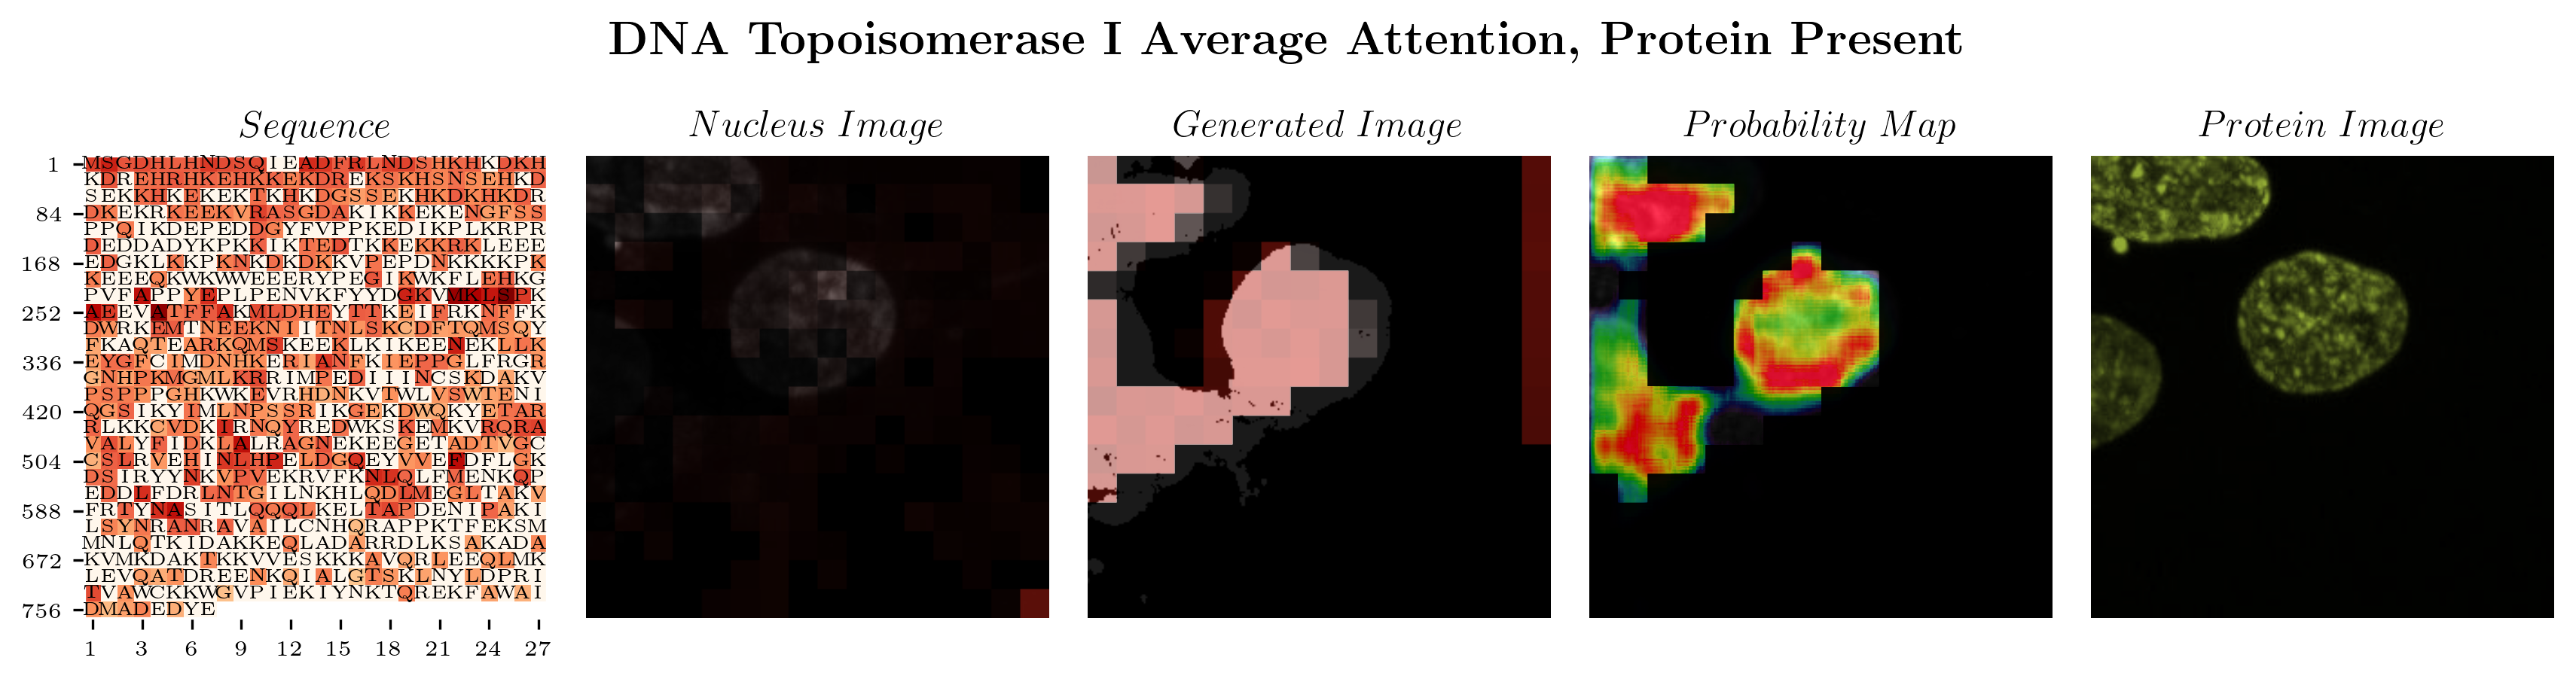

In [11]:
import os
from matplotlib import patches

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"]
})


unpadded_sequence = sequence[:,:np.where(sequence!=0)[-1][-1]+1][0]
if unpadded_sequence[-1] == 3:
    unpadded_sequence = unpadded_sequence[:-2]
protein_letters = [IUPAC_VOCAB_INV[x.item()] for x in unpadded_sequence]

mean_activation_mat = (joint_attentions[-1]).cpu().numpy()
# mean_activation_mat = torch.min(torch.cat(chunked_list,dim=2),dim=1)[0][-1].cpu().numpy()


# max_seq = (mean_activation_mat[-256:][:,2:min(len(unpadded_sequence)+1,1001)]).max()
# min_seq = (mean_activation_mat[-256:][:,2:min(len(unpadded_sequence)+1,1001)]).min()

# max_cond = np.log(mean_activation_mat[-256:][:,1001:1257]).max()
# min_cond = np.log(mean_activation_mat[-256:][:,1001:1257]).min()

# max_im = mean_activation_mat[-256:][:,1257:].max()
# min_im = mean_activation_mat[-256:][:,1257:].min()

tok_pos = 255

# generative_weights = torch.mean(torch.stack(positive_weights),dim=0).numpy()
generative_weights = (torch.mean(torch.stack(positive_weights),dim=0)*cool_weights1).numpy()
relevant_weights = generative_weights
sequence_text_tokens = relevant_weights[1:min(len(unpadded_sequence)+1,1001)]
# sequence_text_tokens[sequence_text_tokens == -inf] = np.min(sequence_text_tokens[sequence_text_tokens>-1e34])
condition_tokens = relevant_weights[1001:1257]
# condition_tokens[condition_tokens == -inf] = np.min(condition_tokens[condition_tokens>-1e34])
image_tokens = relevant_weights[1257:]
# image_tokens[image_tokens == -inf] = np.min(image_tokens[image_tokens>-1e34])
    

#fig = plt.figure(tight_layout=True,)
fig = plt.figure(figsize=(11.5, 3), dpi=300, tight_layout=True, frameon=False, clear=True)
protein_name = 'DNA Topoisomerase I'
fig.suptitle(r'$\textbf{{{protein_name}}}$'.format(protein_name=protein_name) + r'$\textbf{ Average Attention, Protein Present}$', color='black', fontsize = 15)
axes = []


# .0 SEQUENCE PLOT
axes.append(fig.add_subplot(1, 5, 1))
axes[-1].set_title(r'$Sequence$',color='black')

count = 0
text_plot_weights = pad_to_square(sequence_text_tokens) 
text_mask = np.zeros(text_plot_weights.shape)
for i in range(text_plot_weights.shape[0]):
    for j in range(text_plot_weights.shape[1]):
        axes[-1].text(j,i,f'{protein_letters[count]}',ha='center',va='center',color='black', usetex=True,size='xx-small')
        text_mask[i,j] = 1
        count += 1
        if count == len(protein_letters):
            break
    if count == len(protein_letters):
            break
plt.imshow(text_plot_weights,cmap='OrRd')
# plt.clim(min_seq,max_seq)
axes[-1].imshow(text_mask,cmap='white_alpha',alpha = 1)

axes[-1].spines['top'].set_color('white')
axes[-1].tick_params(axis='x', colors='black', labelsize = 'x-small')
axes[-1].tick_params(axis='y', colors='black', labelsize = 'x-small')

y_vals = np.arange(text_plot_weights.shape[0])[::3]
y_range = (text_plot_weights.shape[0]*(y_vals))
y_range[0] = 1
x_vals = np.arange(text_plot_weights.shape[0])[::3]
x_range = x_vals.copy()
x_range[0] = 1

plt.yticks(y_vals,y_range)
plt.xticks(x_vals,x_range)

# .0 NUCLEUS PLOT
axes.append(fig.add_subplot(1, 5, 2))
axes[-1].set_title(r'$Nucleus \ Image$',color='black')
test_nuc = np.ones(nucleus[0,0].shape)
for i in range(condition_tokens.shape[0]):
    x = i * 16 % 256
    y = i // (256 // 16) * 16
    test_nuc[y:y + 16, x:x + 16] *= condition_tokens[i]

axes[-1].axis('off')
axes[-1].imshow(nucleus[0,0],cmap='gray', interpolation= 'bilinear')
plt.imshow(test_nuc,cmap='red_alpha',alpha=.90)
#plt.clim(min_condition_weight,max_condition_weight)
# plt.clim(min_cond,max_cond)


# .0 OUTPUT PLOT
axes.append(fig.add_subplot(1, 5, 3))
axes[-1].set_title(r'$Generated \ Image$',color='black')
image_tokens_u = np.concatenate([image_tokens,np.zeros(1)])
test_im = np.ones(output[0,0].shape)

for i in range(test_im.shape[0]):
    x = i * 16 % 256
    y = i // (256 // 16) * 16
    if i < tok_pos: 
        test_im[y:y + 16, x:x + 16] *= image_tokens_u[i]
    else:
        test_im[y:y + 16, x:x + 16] = 0

        
axes[-1].axis('off')
axes[-1].imshow(np.clip(output[0,0],0,1),cmap='gray',alpha=1, interpolation= 'bilinear')        
plt.imshow(test_im,cmap='red_alpha',alpha=.90)
#plt.clim(min_protein_weight,max_protein_weight)
# plt.clim(min_im,max_im)


# .0 PDF PLOT
axes.append(fig.add_subplot(1, 5, 4))
axes[-1].set_title(r'$Probability \ Map$',color='black')
test_im = np.ones(output[0,0].shape)

for i in range(test_im.shape[0]):
    x = i * 16 % 256
    y = i // (256 // 16) * 16
    
    if i < tok_pos: 
        test_im[y:y + 16, x:x + 16] *= imager[y:y + 16, x:x + 16]
    else:
        test_im[y:y + 16, x:x + 16] = 0

        
axes[-1].axis('off')
axes[-1].imshow(np.clip(nucleus[0,0],0,1),cmap='gray',alpha=1, interpolation= 'bilinear')        
plt.imshow(test_im,cmap='rainbow_alpha',alpha=.80)
#plt.clim(min_protein_weight,max_protein_weight)
#plt.clim(0,1)
axes[-1].imshow(pos_mask,cmap='gray_alpha',alpha=.95)


# .0 PDF PLOT
axes.append(fig.add_subplot(1, 5, 5))
axes[-1].set_title(r'$Protein \ Image$',color='black')

axes[-1].axis('off')
axes[-1].imshow(np.clip(batch['target'][0].cpu(),0,1),cmap='lime_green',alpha=1, interpolation= 'bilinear')        

plt.savefig('DNA Topoisomerase Base.svg',bbox_inches='tight')
plt.show()

In [7]:


import os
from matplotlib import patches


# protein_name = 'Nucleoplasmin (NLS) + Green Fluorescent Protein'

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"]
})


unpadded_sequence = sequence[:,:np.where(sequence!=0)[-1][-1]+1][0]
if unpadded_sequence[-1] == 3:
    unpadded_sequence = unpadded_sequence[:-2]
protein_letters = [IUPAC_VOCAB_INV[x.item()] for x in unpadded_sequence]

mean_activation_mat = (joint_attentions[-1]).cpu().numpy()


generative_weights = mean_activation_mat[-256:]

for tok_pos in tqdm(range(256)):
    relevant_weights = generative_weights[tok_pos]
    sequence_text_tokens = (relevant_weights[1:min(len(unpadded_sequence)+1,1001)])
    condition_tokens = relevant_weights[1001:1257]
    image_tokens = np.log(relevant_weights[1257:])
        
    
    #fig = plt.figure(tight_layout=True,)
    fig = plt.figure(figsize=(17.5, 5), dpi=140, tight_layout=True)
    fig.suptitle(r'$\textbf{{{protein_name}}}$'.format(protein_name=protein_name) +  '\n' + r'$\textbf{Relative Attention Weights}$')
    axes = []


    # .0 SEQUENCE PLOT
    axes.append(fig.add_subplot(1, 4, 1))
    axes[-1].set_title(r'$Sequence$')
    axes[-1].axis('off')
    count = 0
    text_plot_weights = pad_to_square(sequence_text_tokens) 
    text_mask = np.zeros(text_plot_weights.shape)
    for i in range(text_plot_weights.shape[0]):
        for j in range(text_plot_weights.shape[1]):
            axes[-1].text(j,i,f'{protein_letters[count]}',ha='center',va='center',color='black')
            text_mask[i,j] = 1
            count += 1
            if count == len(protein_letters):
                break
        if count == len(protein_letters):
                break
    plt.imshow(text_plot_weights,cmap='OrRd')
    # plt.clim(min_seq,max_seq)
    axes[-1].imshow(text_mask,cmap='gray_alpha',alpha = 1)
    
    
    
    # .0 NUCLEUS PLOT
    axes.append(fig.add_subplot(1, 4, 2))
    axes[-1].set_title(r'$Nucleus \ Image$')
    test_nuc = np.ones(nucleus[0,0].shape)
    for i in range(condition_tokens.shape[0]):
        x = i * 16 % 256
        y = i // (256 // 16) * 16
        test_nuc[y:y + 16, x:x + 16] *= condition_tokens[i]
        
        if i == tok_pos:
            rect = patches.Rectangle((x, y), 16, 16, linewidth=2, edgecolor='blue', facecolor='none')
    axes[-1].axis('off')
    axes[-1].imshow(nucleus[0,0],cmap='gray', interpolation= 'bilinear')
    plt.imshow(test_nuc,cmap='red_alpha',alpha=.90)
    #plt.clim(min_condition_weight,max_condition_weight)
    # plt.clim(min_cond,max_cond)
    axes[-1].add_patch(rect)
    

    # .0 OUTPUT PLOT
    axes.append(fig.add_subplot(1, 4, 3))
    axes[-1].set_title(r'$Predicted \ Threshold \ Image$')
    image_tokens_u = np.concatenate([image_tokens,np.zeros(1)])
    test_im = np.ones(output[0,0].shape)
    im_mask = np.ones(test_im.shape)

    for i in range(test_im.shape[0]):
        x = i * 16 % 256
        y = i // (256 // 16) * 16
        
        if i < tok_pos: 
            test_im[y:y + 16, x:x + 16] *= image_tokens_u[i]
            im_mask[y:y + 16, x:x + 16] = 1
        else:
            test_im[y:y + 16, x:x + 16] = 0
            im_mask[y:y + 16, x:x + 16] = 0
            
        if i == tok_pos:
            rect = patches.Rectangle((x, y), 16, 16, linewidth=2, edgecolor='blue', facecolor='none')
            
    axes[-1].axis('off')
    axes[-1].imshow(np.clip(output[0,0],0,1),cmap='gray',alpha=1, interpolation= 'bilinear')        
    plt.imshow(test_im,cmap='red_alpha',alpha=.90)
    #plt.clim(min_protein_weight,max_protein_weight)
    # plt.clim(min_im,max_im)
    axes[-1].imshow(im_mask,cmap='gray_alpha',alpha=1)
    axes[-1].add_patch(rect)
    
    
    # .0 PDF PLOT
    axes.append(fig.add_subplot(1, 4, 4))
    axes[-1].set_title(r'$Predicted \ PDF$')
    image_tokens_u = np.concatenate([image_tokens,np.zeros(1)])
    test_im = np.ones(output[0,0].shape)
    im_mask = np.ones(test_im.shape)
    
    for i in range(test_im.shape[0]):
        x = i * 16 % 256
        y = i // (256 // 16) * 16
        
        if i < tok_pos: 
            test_im[y:y + 16, x:x + 16] *= imager[y:y + 16, x:x + 16]
            im_mask[y:y + 16, x:x + 16] = 1
        else:
            test_im[y:y + 16, x:x + 16] = 0
            im_mask[y:y + 16, x:x + 16] = 0
            
        if i == tok_pos:
            rect = patches.Rectangle((x, y), 16, 16, linewidth=2, edgecolor='blue', facecolor='none')
            
    axes[-1].axis('off')
    axes[-1].imshow(np.clip(nucleus[0,0],0,1),cmap='gray',alpha=1, interpolation= 'bilinear')        
    plt.imshow(test_im,cmap='rainbow_alpha',alpha=.80)
    #plt.clim(min_protein_weight,max_protein_weight)
    #plt.clim(0,1)
    #axes[-1].imshow(im_mask.cpu(),cmap='gray_alpha',alpha=1)
    axes[-1].add_patch(rect)
    
    plt.savefig(f'temp/{tok_pos}.jpg')
    plt.close(fig)
    
    
    #.1
    
    fig = plt.figure(figsize=(17.5, 5), dpi=140, tight_layout=True)
    fig.suptitle(r'$\textbf{{{protein_name}}}$'.format(protein_name=protein_name) +  '\n' + r'$\textbf{Relative Attention Weights}$')
    axes = []


    # .1 SEQUENCE PLOT
    axes.append(fig.add_subplot(1, 4, 1))
    axes[-1].set_title(r'$Sequence$')
    axes[-1].axis('off')
    count = 0
    text_plot_weights = pad_to_square(sequence_text_tokens) 
    text_mask = np.zeros(text_plot_weights.shape)
    for i in range(text_plot_weights.shape[0]):
        for j in range(text_plot_weights.shape[1]):
            axes[-1].text(j,i,f'{protein_letters[count]}',ha='center',va='center',color='black')
            text_mask[i,j] = 1
            count += 1
            if count == len(protein_letters):
                break
        if count == len(protein_letters):
                break
    plt.imshow(text_plot_weights,cmap='OrRd')
    # plt.clim(min_seq,max_seq)
    axes[-1].imshow(text_mask,cmap='gray_alpha',alpha = 1)
    
    
    
    # .1 NUCLEUS PLOT
    axes.append(fig.add_subplot(1, 4, 2))
    axes[-1].set_title(r'$Nucleus \ Image$')
    test_nuc = np.ones(nucleus[0,0].shape)
    for i in range(condition_tokens.shape[0]):
        x = i * 16 % 256
        y = i // (256 // 16) * 16
        test_nuc[y:y + 16, x:x + 16] *= condition_tokens[i]
        
        if i == tok_pos:
            rect = patches.Rectangle((x, y), 16, 16, linewidth=2, edgecolor='blue', facecolor='none')
    axes[-1].axis('off')
    axes[-1].imshow(nucleus[0,0],cmap='gray', interpolation= 'bilinear')
    plt.imshow(test_nuc,cmap='red_alpha',alpha=.90)
    #plt.clim(min_condition_weight,max_condition_weight)
    # plt.clim(min_cond,max_cond)
    axes[-1].add_patch(rect)
    

    # .1 OUTPUT PLOT
    axes.append(fig.add_subplot(1, 4, 3))
    axes[-1].set_title(r'$Predicted \ Threshold \ Image$')
    image_tokens_u = np.concatenate([image_tokens,np.zeros(1)])
    test_im = np.ones(output[0,0].shape)
    im_mask = np.ones(test_im.shape)

    for i in range(test_im.shape[0]):
        x = i * 16 % 256
        y = i // (256 // 16) * 16
        
        if i <= tok_pos: 
            test_im[y:y + 16, x:x + 16] *= image_tokens_u[i]
            im_mask[y:y + 16, x:x + 16] = 1
        else:
            test_im[y:y + 16, x:x + 16] = 0
            im_mask[y:y + 16, x:x + 16] = 0
            
        if i == tok_pos:
            rect = patches.Rectangle((x, y), 16, 16, linewidth=2, edgecolor='blue', facecolor='none')
            
    axes[-1].axis('off')
    axes[-1].imshow(np.clip(output[0,0],0,1),cmap='gray',alpha=1, interpolation= 'bilinear')        
    plt.imshow(test_im,cmap='red_alpha',alpha=.90)
    #plt.clim(min_protein_weight,max_protein_weight)
    # plt.clim(min_im,max_im)
    axes[-1].imshow(im_mask,cmap='gray_alpha',alpha=1)
    axes[-1].add_patch(rect)
    
    
    # .1 PDF PLOT
    axes.append(fig.add_subplot(1, 4, 4))
    axes[-1].set_title(r'$Predicted \ PDF$')
    image_tokens_u = np.concatenate([image_tokens,np.zeros(1)])
    test_im = np.ones(output[0,0].shape)
    im_mask = np.ones(test_im.shape)
    
    for i in range(test_im.shape[0]):
        x = i * 16 % 256
        y = i // (256 // 16) * 16
        
        if i <= tok_pos: 
            test_im[y:y + 16, x:x + 16] *= imager[y:y + 16, x:x + 16]
            im_mask[y:y + 16, x:x + 16] = 1
        else:
            test_im[y:y + 16, x:x + 16] = 0
            im_mask[y:y + 16, x:x + 16] = 0
            
        if i == tok_pos:
            rect = patches.Rectangle((x, y), 16, 16, linewidth=2, edgecolor='blue', facecolor='none')
            
    axes[-1].axis('off')
    axes[-1].imshow(np.clip(nucleus[0,0],0,1),cmap='gray',alpha=1, interpolation= 'bilinear')        
    plt.imshow(test_im,cmap='rainbow_alpha',alpha=.80)
    #plt.clim(min_protein_weight,max_protein_weight)
    #plt.clim(0,1)
    #axes[-1].imshow(im_mask.cpu(),cmap='gray_alpha',alpha=1)
    axes[-1].add_patch(rect)
    
    plt.savefig(f'temp/{tok_pos}.1.jpg')
    plt.close(fig)
   
    
import glob
from PIL import Image

def get_key(fp):
    filename = os.path.splitext(os.path.basename(fp))[0]
    int_part = filename.split()[0]
    return float(int_part)

# filepaths
fp_in = "temp/*.jpg"
fp_out = f"temp/{protein_name}.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
imgs = (Image.open(f) for f in sorted(glob.glob(fp_in), key=get_key))
# img = next(imgs)  # extract first image from iterator
# img.save(fp=fp_out, format='GIF', append_images=imgs,
#          save_all=True, duration=150, loop=0)

  0%|          | 0/256 [00:00<?, ?it/s]/tmp/ipykernel_1449950/918605431.py:28: RuntimeWarning: divide by zero encountered in log
  image_tokens = np.log(relevant_weights[1257:])
  0%|          | 1/256 [00:11<48:55, 11.51s/it]/tmp/ipykernel_1449950/918605431.py:28: RuntimeWarning: divide by zero encountered in log
  image_tokens = np.log(relevant_weights[1257:])
100%|██████████| 256/256 [27:19<00:00,  6.41s/it]


In [39]:
import cv2
import os

def write_video(file_path, frames, fps):
    """
    Writes frames to an mp4 video file
    :param file_path: Path to output video, must end with .mp4
    :param frames: List of PIL.Image objects
    :param fps: Desired frame rate
    """

    w, h = frames[0].size
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    writer = cv2.VideoWriter(file_path, fourcc, fps, (1280, 366))

    for frame in frames:
        writer.write(cv2.resize(cv2.cvtColor(np.array(frame),cv2.COLOR_RGB2BGR),(1280,366),fx=0,fy=0,interpolation=cv2.INTER_CUBIC))

    writer.release() 

In [41]:
imgs = (Image.open(f) for f in sorted(glob.glob(fp_in), key=get_key))

write_video(fp_out.replace('gif','mp4'),[img for img in imgs],15)